# Smart Search: Q&A

### Imports

In [396]:
import logging
import multiprocessing as mp
from collections.abc import (
    Iterable,
    Sequence,
)
from pathlib import Path

import pandas as pd
import more_itertools as mit
import gensim
import nltk
import unidecode
from gensim.models import (
    doc2vec,
)
from sklearn import (
    dummy,
    decomposition,
    preprocessing,
    metrics,
    model_selection,
    naive_bayes,
    linear_model,
)

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%aimport autoreply.dataset
%aimport autoreply.constants
%aimport autoreply.misc_data

%aimport autoreply.modeling
%aimport autoreply.modeling.eda
%aimport autoreply.modeling.model
%aimport autoreply.modeling.preprocess
%aimport autoreply.modeling.evaluate


from autoreply import (
    misc_data,
    constants as C,
    modeling,
)

In [4]:
logging.basicConfig(level=logging.WARNING, force=True)

## EDA

In [5]:
db = misc_data.DBResult.load()

### Data view

#### Title

In [86]:
db.title

,title_id,title
0,0,Frédéric_Chopin
1,1,IPod
2,2,The_Legend_of_Zelda:_Twilight_Princess
3,3,Spectre_(2015_film)
4,4,2008_Sichuan_earthquake
...,...,...
289,289,"Richmond,_Virginia"
290,290,Infection
291,291,Kathmandu
292,292,Myocardial_infarction


#### Paragraph

In [8]:
db.paragraph

,title_id,para_id,context
0,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...
1,0,1,At the age of 21 he settled in Paris. Thereaft...
2,0,2,All of Chopin's compositions include the piano...
3,0,3,"In his native Poland, in France, where he comp..."
4,0,4,"Fryderyk Chopin was born in Żelazowa Wola, 46 ..."
...,...,...,...
12826,293,24,Isaac Newton (1643–1727) inherited Descartes' ...
12827,293,25,"There is an entire literature concerning the ""..."
12828,293,26,In the late 19th century with the discovery of...
12829,293,27,These quarks and leptons interact through four...


#### Title/Para

In [9]:
modeling.eda.summary(db)

,title,para_id,question
title_id,,,
0,Frédéric_Chopin,82,697
1,IPod,60,327
2,The_Legend_of_Zelda:_Twilight_Princess,32,374
3,Spectre_(2015_film),43,462
4,2008_Sichuan_earthquake,77,521
...,...,...,...
289,"Richmond,_Virginia",61,291
290,Infection,30,290
291,Kathmandu,58,276


#### Question

In [10]:
db.ques_ans

,title_id,para_id,ques_ans_id,question,is_impossible
0,0,0,56cbd2356d243a140015ed66,What was Frédéric's nationalities?,False
1,0,0,56cbd2356d243a140015ed67,In what era was Frédéric active in?,False
2,0,0,56cbd2356d243a140015ed68,For what instrument did Frédéric write primari...,False
3,0,0,56cbd2356d243a140015ed69,In what area was Frédéric born in?,False
4,0,0,56cbd2356d243a140015ed6a,At what age did Frédéric depart from Poland?,False
...,...,...,...,...,...
86563,293,28,5a7e070b70df9f001a875439,Physics has broadly agreed on the definition o...,True
86564,293,28,5a7e070b70df9f001a87543a,Who coined the term partonic matter?,True
86565,293,28,5a7e070b70df9f001a87543b,What is another name for anti-matter?,True
86566,293,28,5a7e070b70df9f001a87543c,Matter usually does not need to be used in con...,True


#### Answer 

In [11]:
db.answer

,ques_ans_id,ans_id,answer,answer_start
0,56cbd2356d243a140015ed66,0,Polish and French,182
1,56cbd2356d243a140015ed67,0,Romantic era,276
2,56cbd2356d243a140015ed68,0,solo piano,318
3,56cbd2356d243a140015ed69,0,Duchy of Warsaw,559
4,56cbd2356d243a140015ed6a,0,20,777
...,...,...,...,...
58596,5735d259012e2f140011a09d,0,Oregon,229
58597,5735d259012e2f140011a09e,0,Rangoon,414
58598,5735d259012e2f140011a09f,0,Minsk,476
58599,5735d259012e2f140011a0a0,0,1975,199


## Train Test

In [312]:
train, dev = model_selection.train_test_split(
    dbs.paragraph, stratify=dbs.paragraph.title_id
)

In [323]:
def make_report(y_true, y_pred) -> pd.DataFrame:
    return pd.DataFrame(
        metrics.classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    ).T

In [413]:
def summarize_report(class_report: pd.DataFrame) -> pd.DataFrame:
    prec_rec_f1_df = class_report.iloc[:-3]
    support = np.clip(np.log(prec_rec_f1_df['support'] + 1e-6), 0, None).to_numpy()
    prec_rec_f1 = (
        prec_rec_f1_df.loc[:, :'f1-score'] * support.reshape(-1, 1)
    ).sum() / support.sum()
    rest = class_report.iloc[-3:, 0]
    return pd.concat([prec_rec_f1, rest]).to_frame('Values')

## Doc2Vec

In [317]:
def make_docs(para: pd.DataFrame) -> list[doc2vec.TaggedDocument]:
    documents = [
        doc2vec.TaggedDocument(modeling.preprocess.main(txt), [title])
        for title, para, txt in db.paragraph.to_numpy()
    ]
    return documents


# documents = [doc2vec.TaggedDocument(preprocess(txt), [f'{title}-{para}']) for title, para, txt in db.paragraph.to_numpy()]

In [320]:
train_docs = make_docs(train)

#### Model 1

In [408]:
# doc_model = doc2vec.Doc2Vec(vector_size=100)
# doc_model.build_vocab(documents)
# doc_model.train(train_docs, total_examples=doc_model.corpus_count, epochs=10)

In [409]:
# doc_model.save('doc2vec-100.joblib')

In [391]:
doc_model = doc2vec.Doc2Vec.load('doc2vec-100.joblib')

In [407]:
vecs = [doc_model.infer_vector(doc.words) for doc in train_docs]

In [393]:
paras = db.paragraph.title_id

In [394]:
log_clf = linear_model.LogisticRegressionCV(solver='sag')

In [397]:
scaler = preprocessing.StandardScaler()

In [398]:
scaled = scaler.fit_transform(vecs)

In [403]:
log_clf.fit(scaled, paras)

In [404]:
train

,title_id,para_id,context
9583,215,7,Apollo was worshipped as Actiacus (/ækˈtaɪ.əkə...
11789,273,35,Only scant remains prove that mosaics were sti...
8306,187,28,Deforestation and forest fires are a problem i...
7744,173,21,Proponents of affirmative action argue that by...
7206,159,14,World War I was a watershed event in human his...
...,...,...,...
10898,250,51,"As of 2012[update], there are over 3.5 million..."
10292,237,33,"In April 1758, the British concluded the Anglo..."
10325,238,5,Gaddafi's earliest education was of a religiou...
5788,128,53,The official Cubs team mascot is a young bear ...


In [410]:
pred_tags = modeling.evaluate.results(train['context'], doc_model, epochs=5)

In [416]:
summarize_report(make_report(train.title_id, pred_tags))

,Values
precision,0.727777
recall,0.679213
f1-score,0.663283
accuracy,0.665697
macro avg,0.704003
weighted avg,0.779773


In [417]:
dev_tags = modeling.evaluate.results(dev['context'], doc_model, epochs=5)

In [418]:
summarize_report(make_report(dev.title_id, dev_tags))

,Values
precision,0.752931
recall,0.686947
f1-score,0.675623
accuracy,0.675810
macro avg,0.716798
weighted avg,0.791727


In [420]:
test_tags = modeling.evaluate.results(test['question'], doc_model, epochs=5)

In [33]:
# _N = os.cpu_count()
# sections = mit.distribute(_N, db.paragraph['context'])
# with mp.Pool(_N) as pool:
#     res = list(mit.flatten(pool.map(modeling.evaluate.Eval(doc_model1), sections)))

In [422]:
summarize_report(make_report(test.title_id, test_tags))

,Values
precision,0.331330
recall,0.257187
f1-score,0.266579
accuracy,0.262060
macro avg,0.322313
weighted avg,0.370558


## Ques_ans pred

In [39]:
qa_tags = modeling.evaluate.results(db.ques_ans['question'], doc_model)

In [365]:
print(metrics.classification_report(db.ques_ans.title_id, pred_tags))

In [116]:
modeling.eda.get_context(db, 192, 17)

"Greater London's population declined steadily in the decades after the Second World War, from an estimated peak of 8.6 million in 1939 to around 6.8 million in the 1980s. The principal ports for London moved downstream to Felixstowe and Tilbury, with the London Docklands area becoming a focus for regeneration, including the Canary Wharf development. This was borne out of London's ever-increasing role as a major international financial centre during the 1980s. The Thames Barrier was completed in the 1980s to protect London against tidal surges from the North Sea."

## BERT

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

In [58]:
print(metrics.accuracy_score(id_0.ques_ans.para_id, res))

0.6872309899569584


### TF-IDF

In [108]:
vec = TfidfVectorizer(strip_accents='ascii', max_df=0.9)

In [110]:
vec.fit(id_0.paragraph['context'])

TfidfVectorizer(max_df=0.9, strip_accents='ascii')

In [112]:
t = id_0.paragraph

In [115]:
trans = vec.transform(t['context'])

In [172]:
unidecode(modeling.eda.get_context(db, 0, 80))

"Chopin's qualities as a pianist and composer were recognized by many of his fellow musicians. Schumann named a piece for him in his suite Carnaval, and Chopin later dedicated his Ballade No. 2 in F major to Schumann. Elements of Chopin's music can be traced in many of Liszt's later works. Liszt later transcribed for piano six of Chopin's Polish songs. A less fraught friendship was with Alkan, with whom he discussed elements of folk music, and who was deeply affected by Chopin's death."

In [174]:
_text = '''What other musician shows to have elements'''
# res = metrics.pairwise_distances(trans, vec.transform([t['context'][0]]), metric='cosine')
res = metrics.pairwise_distances(trans, vec.transform([_text]), metric='cosine')

In [176]:
idxs = np.argsort(res, axis=0).ravel()

In [177]:
res[idxs[:10]]

array([[0.82322305],
       [0.90158308],
       [0.90901296],
       [0.90911767],
       [0.91320089],
       [0.92096742],
       [0.92273303],
       [0.92468014],
       [0.93144871],
       [0.93532793]])

In [178]:
t.iloc[idxs[:10]]

,title_id,para_id,context
80,0,80,Chopin's qualities as a pianist and composer w...
73,0,73,Jonathan Bellman writes that modern concert pe...
22,0,22,Although it is not known exactly when Chopin f...
31,0,31,"From 1842 onwards, Chopin showed signs of seri..."
21,0,21,"In the spring of 1834, Chopin attended the Low..."
69,0,69,"The two mature piano sonatas (No. 2, Op. 35, w..."
36,0,36,Chopin's life and his relations with George Sa...
24,0,24,Although the two displayed great respect and a...
50,0,50,Chopin's disease and the cause of his death ha...
44,0,44,In London Chopin took lodgings at Dover Street...


### Basic Classifier

In [17]:
vec, svd, X, y = modeling.model.svd(db)

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
min_max = MinMaxScaler()

In [30]:
trans_title = min_max.fit_transform(db.title.title_id.to_numpy().reshape(-1, 1))

In [22]:
db.paragraph

,title_id,para_id,context
0,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...
1,0,1,At the age of 21 he settled in Paris. Thereaft...
2,0,2,All of Chopin's compositions include the piano...
3,0,3,"In his native Poland, in France, where he comp..."
4,0,4,"Fryderyk Chopin was born in Żelazowa Wola, 46 ..."
...,...,...,...
12826,293,24,Isaac Newton (1643–1727) inherited Descartes' ...
12827,293,25,"There is an entire literature concerning the ""..."
12828,293,26,In the late 19th century with the discovery of...
12829,293,27,These quarks and leptons interact through four...


In [21]:
X.shape

(12831, 100)

In [33]:
from sklearn import linear_model

In [79]:
# idxs = np.random.choice(range(len(X)), 500,replace=False)

In [69]:
# db.paragraph.loc[idxs, 'title_id'].to_numpy()

array([189, 218,  57, 265, 194], dtype=int64)

In [88]:
db.paragraph.groupby('title_id')['para_id'].count().sort_values(ascending=False)

title_id
9      149
5      148
10     127
283     98
49      95
      ... 
93      13
71      12
86      12
79      12
74      10
Name: para_id, Length: 294, dtype: int64

In [89]:
binary = db.paragraph.loc[:, 'title_id'].map(lambda x: 0 if x != 9 else 1)

In [90]:
# log_clf.fit(X[idxs], db.paragraph.loc[idxs, 'title_id'].to_numpy())
log_clf = linear_model.LogisticRegressionCV()
log_clf.fit(X[idxs], binary[idxs])

LogisticRegressionCV()

In [91]:
y_pred = log_clf.predict(X[idxs])

In [92]:
from sklearn import metrics

metrics.accuracy_score(db.paragraph.title_id.loc[idxs], y_pred)

0.004

## Arbitrary

In [328]:
# dbs = modeling.eda.filter_db(db, range(5))
dbs = db

In [329]:
# res, vec = modeling.model.alt_predict(db)

In [330]:
_STOPWORDS = set(nltk.corpus.stopwords.words('english'))

In [331]:
vec = feature_extraction.text.TfidfVectorizer(
    strip_accents='ascii',
    stop_words=_STOPWORDS,
    ngram_range=(1, 2),
    min_df=5,
)

train_X = vec.fit_transform(train['context'])
dev_X = vec.transform(dev['context'])

In [389]:
train['context']

9583     Apollo was worshipped as Actiacus (/ækˈtaɪ.əkə...
11789    Only scant remains prove that mosaics were sti...
8306     Deforestation and forest fires are a problem i...
7744     Proponents of affirmative action argue that by...
7206     World War I was a watershed event in human his...
                               ...                        
10898    As of 2012[update], there are over 3.5 million...
10292    In April 1758, the British concluded the Anglo...
10325    Gaddafi's earliest education was of a religiou...
5788     The official Cubs team mascot is a young bear ...
5481     Before the Hellenistic period, Greek colonies ...
Name: context, Length: 9623, dtype: object

In [332]:
len(vec.vocabulary_)

19500

In [338]:
test = dbs.ques_ans
test_X = vec.transform(test['question'])

#### Logistic

In [75]:
svd = decomposition.TruncatedSVD(100)

In [76]:
out_x = svd.fit_transform(train_X)

In [77]:
out_t_x = svd.transform(test_X)

In [78]:
out_x.shape, out_t_x.shape

((3392, 100), (1131, 100))

In [ ]:
log_clf = linear_model.LogisticRegressionCV()

In [81]:
log_clf.fit(out_x, train.title_id)

C:\Users\wb570819\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\wb570819\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.or

LogisticRegressionCV()

In [82]:
print(metrics.classification_report(train.title_id, log_clf.predict(out_x)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        45
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        32
           4       1.00      0.98      0.99        58
           5       1.00      1.00      1.00       111
           6       1.00      1.00      1.00        46
           7       1.00      1.00      1.00        39
           8       1.00      1.00      1.00        59
           9       1.00      1.00      1.00       112
          10       1.00      1.00      1.00        95
          11       1.00      1.00      1.00        56
          12       0.98      1.00      0.99        55
          13       1.00      1.00      1.00        29
          14       1.00      1.00      1.00        16
          15       1.00      1.00      1.00        17
          16       1.00      1.00      1.00        34
          17       1.00    

In [83]:
print(metrics.classification_report(test.title_id, log_clf.predict(out_t_x)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       0.93      0.87      0.90        15
           2       1.00      1.00      1.00         8
           3       1.00      0.91      0.95        11
           4       0.88      0.79      0.83        19
           5       0.88      0.95      0.91        37
           6       0.88      0.88      0.88        16
           7       0.92      0.92      0.92        13
           8       1.00      0.95      0.97        20
           9       0.74      1.00      0.85        37
          10       0.94      1.00      0.97        32
          11       1.00      0.89      0.94        19
          12       0.90      1.00      0.95        19
          13       0.88      0.70      0.78        10
          14       0.57      0.80      0.67         5
          15       0.60      0.50      0.55         6
          16       0.83      0.83      0.83        12
          17       1.00    

C:\Users\wb570819\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wb570819\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wb570819\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificatio

#### Naive

In [333]:
nb_clf = naive_bayes.MultinomialNB()

In [334]:
nb_clf.fit(train_X, train.title_id)

MultinomialNB()

In [335]:
nb_clf.predict(train_X)

array([215, 273, 187, ..., 238, 128, 122], dtype=int64)

In [366]:
train_report = make_report(train.title_id, nb_clf.predict(train_X))
train_report

,precision,recall,f1-score,support
0,0.983871,1.000000,0.991870,61.000000
1,0.978261,1.000000,0.989011,45.000000
2,1.000000,0.833333,0.909091,24.000000
3,1.000000,0.781250,0.877193,32.000000
4,0.934426,0.982759,0.957983,58.000000
...,...,...,...,...
292,1.000000,0.500000,0.666667,20.000000
293,1.000000,0.772727,0.871795,22.000000
accuracy,0.741868,0.741868,0.741868,0.741868
macro avg,0.816956,0.610608,0.651838,9623.000000


In [367]:
dev_report = make_report(dev.title_id, nb_clf.predict(dev_X))
dev_report

,precision,recall,f1-score,support
0,0.952381,0.952381,0.952381,21.000000
1,0.875000,0.933333,0.903226,15.000000
2,1.000000,0.375000,0.545455,8.000000
3,1.000000,0.454545,0.625000,11.000000
4,0.937500,0.789474,0.857143,19.000000
...,...,...,...,...
292,0.000000,0.000000,0.000000,6.000000
293,0.000000,0.000000,0.000000,7.000000
accuracy,0.508105,0.508105,0.508105,0.508105
macro avg,0.567362,0.367407,0.405401,3208.000000


In [375]:
test_report = make_report(test.title_id, nb_clf.predict(test_X))

In [376]:
test_report

,precision,recall,f1-score,support
0,0.874791,0.751793,0.808642,697.000000
1,0.937255,0.730887,0.821306,327.000000
2,1.000000,0.219251,0.359649,374.000000
3,1.000000,0.149351,0.259887,462.000000
4,0.730159,0.353167,0.476067,521.000000
...,...,...,...,...
292,0.000000,0.000000,0.000000,126.000000
293,1.000000,0.014085,0.027778,142.000000
accuracy,0.262164,0.262164,0.262164,0.262164
macro avg,0.624719,0.225096,0.270268,86568.000000


In [372]:
np.clip(np.log(test_report['support'] + 1e-6), 0, None)

0                6.546785
1                5.789960
2                5.924256
3                6.135565
4                6.255750
                  ...    
292              4.836282
293              4.955827
accuracy         0.000000
macro avg       11.368686
weighted avg    11.368686
Name: support, Length: 297, dtype: float64

In [385]:
summarize_report(train_report)

,Values
precision,0.835489
recall,0.652123
f1-score,0.685367
accuracy,0.741868
macro avg,0.816956
weighted avg,0.852726


In [387]:
summarize_report(dev_report)

,Values
precision,0.620326
recall,0.428738
f1-score,0.460206
accuracy,0.508105
macro avg,0.567362
weighted avg,0.661719


In [309]:
summarize_report(test_report)

,Values
precision,0.645213
recall,0.232074
f1-score,0.275973
accuracy,0.263053
macro avg,0.635517
weighted avg,0.672870


In [234]:
proba = nb_clf.predict_proba(test_X[10000])

<BarContainer object of 294 artists>

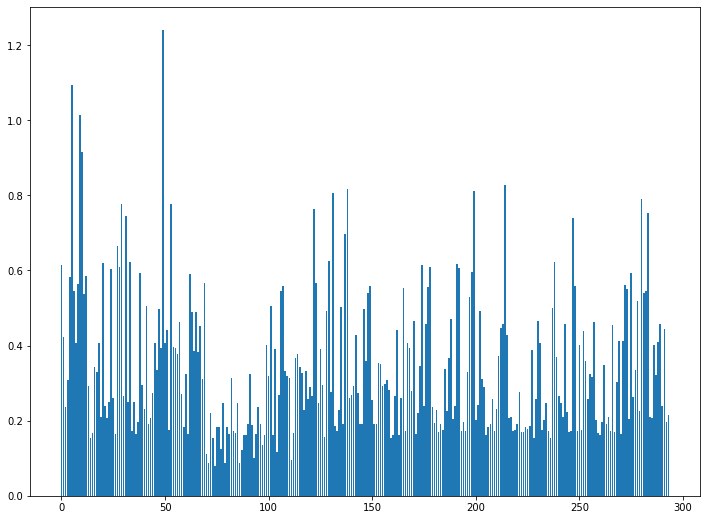

In [235]:
plt.figure(figsize=(12, 9))
plt.bar(np.arange(len(proba.ravel())), proba.ravel() * 100)

### Distance Similarity

In [192]:
res = [np.argmin(metrics.pairwise_distances(out_x, [_y])) for _y in out_y]

In [188]:
res

[3574, 3329, 4411, 10075, 2606, 52, 30, 67, 1402, 52]

In [164]:
res

Result(accuracy=0.6452365796732442, n_paras=784, n_ques=4713)

In [156]:
dist = metrics.pairwise_distances(
    vec.transform(dbs.paragraph['context']), vec.transform(['this is chopin'])
)

In [162]:
dbs.paragraph.iloc[74]

title_id                                                    0
para_id                                                    74
context     Chopin's music is frequently played with rubat...
Name: 74, dtype: object

In [144]:
vals = {}
for i in range(10):
    _id = modeling.eda.filter_db(db, {i})
    vals[i] = modeling.model.predict(_id)

In [146]:
vals

{0: Result(accuracy=0.6886657101865137, n_paras=82, n_ques=697),
 1: Result(accuracy=0.6116207951070336, n_paras=60, n_ques=327),
 2: Result(accuracy=0.6417112299465241, n_paras=32, n_ques=374),
 3: Result(accuracy=0.7034632034632035, n_paras=43, n_ques=462),
 4: Result(accuracy=0.7543186180422264, n_paras=77, n_ques=521),
 5: Result(accuracy=0.7564259485924113, n_paras=148, n_ques=817),
 6: Result(accuracy=0.631578947368421, n_paras=62, n_ques=228),
 7: Result(accuracy=0.8514056224899599, n_paras=52, n_ques=249),
 8: Result(accuracy=0.5817757009345794, n_paras=79, n_ques=428),
 9: Result(accuracy=0.7721311475409836, n_paras=149, n_ques=610)}

In [150]:
sum(val.accuracy * val.n_ques for val in vals.values()) / sum(
    val.n_ques for val in vals.values()
)

0.706980691703798

In [75]:
para = db.paragraph
ques = db.ques_ans

In [85]:
metrics.accuracy_score([[1, 2]], [[2, 2]])

0.0

In [107]:
pd.merge(para, db.ques_ans, on=['title_id', 'para_id'])

,title_id,para_id,context,ques_ans_id,question,is_impossible
0,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...,56cbd2356d243a140015ed66,What was Frédéric's nationalities?,False
1,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...,56cbd2356d243a140015ed67,In what era was Frédéric active in?,False
2,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...,56cbd2356d243a140015ed68,For what instrument did Frédéric write primari...,False
3,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...,56cbd2356d243a140015ed69,In what area was Frédéric born in?,False
4,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...,56cbd2356d243a140015ed6a,At what age did Frédéric depart from Poland?,False
...,...,...,...,...,...,...
86563,293,28,"The term ""matter"" is used throughout physics i...",5a7e070b70df9f001a875439,Physics has broadly agreed on the definition o...,True
86564,293,28,"The term ""matter"" is used throughout physics i...",5a7e070b70df9f001a87543a,Who coined the term partonic matter?,True
86565,293,28,"The term ""matter"" is used throughout physics i...",5a7e070b70df9f001a87543b,What is another name for anti-matter?,True
86566,293,28,"The term ""matter"" is used throughout physics i...",5a7e070b70df9f001a87543c,Matter usually does not need to be used in con...,True


In [108]:
vec = TfidfVectorizer(strip_accents='ascii', ngram_range=(1, 2), max_df=0.7)

X = vec.fit_transform(para.context)

In [112]:
y = vec.transform(ques['question'])

In [118]:
# metrics.pairwise_distances(X, y[5])
res = [np.argmin(metrics.pairwise_distances(X, _y)) for _y in y[:10]]

In [120]:
para.iloc[res]

,title_id,para_id,context
7654,170,52,"With the fall of the Western Roman Empire, the..."
1658,27,18,The final name for the republic during the Sov...
0,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...
0,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...
0,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...
80,0,80,Chopin's qualities as a pianist and composer w...
1658,27,18,The final name for the republic during the Sov...
80,0,80,Chopin's qualities as a pianist and composer w...
614,8,58,"On August 30, 2015, West was presented with th..."
41,0,41,Chopin's music remains very popular and is reg...


## Dummy

In [10]:
d_clf_title = dummy.DummyClassifier()

In [14]:
d_clf_title.fit(db.paragraph['context'], db.paragraph.title_id)

DummyClassifier()

In [15]:
d_clf_title.score(db.paragraph['context'], db.paragraph.title_id)

0.011612500974203101

In [7]:
d_clf = dummy.DummyClassifier()

In [8]:
d_clf.fit(db.ques_ans.question, db.ques_ans.title_id)

DummyClassifier()

In [9]:
d_clf.score(db.ques_ans.question, db.ques_ans.title_id)

0.009437667498382775